# Quantile Trading Strategy of Energy Stocks

In [1]:
library(tidyverse)
library(Quandl)
library(PerformanceAnalytics)
library(lubridate)
library(knitr)

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
funding_rate <- 0.02
repo_rate <- funding_rate- .01
weekly_repo_rate <- repo_rate*(1/52)

initial_k = 10000000

For this assignment, I am constructing a quantile trading strategy focusing on the energy and basic materials sectors that will rebalance weekly. Here is my selection criteria:

* end-of-day adjusted closing prices are available , over the entire period Jan 2014 through Jan 2021
* debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 (preferably more than fleetingly)
* not in the automotive, financial or insurance sector , over the entire period Jan 2014 through Jan 2021
* has feasible calculation of the ratios specified below , over the entire period Jan 2014 through Jan 2021,
* Did not have a share price below $0.5 at any point in the period
* Had a market cap greater than 50 million for the entire period
* Is in the energy, basic materials, or industrial materials sector

For factors, I will look at:
* debt to market cap
* Return on Investment
* Price to Earnings
* Price to Earnings Adjusted Return on Investment
 
I am defining Price to Earnings Adjusted Return on Investment as $\frac{Return~on~Investment}{Price~to~Earnings}$

For Strategies, I will test:
* going long the top decile of scores and short the bottom decile of scores with equal weights
* going long the top decile of score changes and short the bottom decile of score changes with equal weights
* going long the top decile of scores and short the bottom decile of scores with the top/bottom 5% recieving 4% positions and the 5%-10% range recieving 1% positions

### data processing

In [3]:
MT <- read_csv('ZACKS_MT.csv')

US_tickers <- MT %>% filter(country_code == 'US') %>% pull(m_ticker)

MKTV <- read_csv('ZACKS_MKTV.csv') %>%
  select(m_ticker, per_type, per_end_date, mkt_val) %>%
  filter(m_ticker %in% US_tickers)

FC <- read_csv('ZACKS_FC.csv') %>%
  filter(m_ticker %in% US_tickers)

FR <- read_csv('ZACKS_FR.csv') %>%
  filter(m_ticker %in% US_tickers)

SHRS <- read_csv('ZACKS_SHRS.csv') %>%
  select(m_ticker, ticker, per_type,per_end_date, shares_out) %>%
  filter(m_ticker %in% US_tickers)

fundamentals_quarterly <- FC %>% 
  full_join(FR, by = colnames(FC)[colnames(FC) %in% colnames(FR)]) %>%
  filter(per_type=='Q') %>%
  filter(currency_code=='USD') %>%
  filter(per_end_date >= as.Date('2011-12-31')) %>%
  filter(per_end_date < as.Date('2021-12-31')) %>%
  left_join(SHRS, by = colnames(FC)[colnames(FC) %in% colnames(SHRS)]) %>% 
  left_join(MKTV,by = colnames(FC)[colnames(FC) %in% colnames(MKTV)]) %>% 
  select(m_ticker, per_end_date, filing_date, per_fisc_year, per_fisc_qtr, per_cal_year, 
         per_cal_qtr, tot_debt_tot_equity, ret_invst, free_cash_flow_per_share, net_lterm_debt, tot_lterm_debt, eps_diluted_net, basic_net_eps, shares_out, mkt_val)  

fundamentals_annual <- FC %>% 
  full_join(FR, by = colnames(FC)[colnames(FC) %in% colnames(FR)]) %>%
  filter(per_type=='A') %>%
  filter(currency_code=='USD') %>%
  filter(per_end_date >= as.Date('2011-12-31')) %>%
  filter(per_end_date < as.Date('2021-12-31')) %>%
  left_join(SHRS, by = colnames(FC)[colnames(FC) %in% colnames(SHRS)]) %>% 
  left_join(MKTV,by = colnames(FC)[colnames(FC) %in% colnames(MKTV)]) %>% 
  select(m_ticker, per_end_date, filing_date, per_fisc_year, per_fisc_qtr, per_cal_year, 
         per_cal_qtr, tot_debt_tot_equity, ret_invst, free_cash_flow_per_share, net_lterm_debt, tot_lterm_debt, eps_diluted_net, basic_net_eps, shares_out, mkt_val)

annual_long <- fundamentals_annual %>% 
  pivot_longer(-c(m_ticker, per_end_date, filing_date, per_fisc_year, per_fisc_qtr, per_cal_year, per_cal_qtr), names_to = 'field', values_to = 'A')

# bind together annual and quarterly data to find data to use
quarterly_long <- fundamentals_quarterly %>% 
  pivot_longer(-c(m_ticker, per_end_date, filing_date, per_fisc_year, per_fisc_qtr, per_cal_year, per_cal_qtr), names_to = 'field', values_to = 'Q')

quarterly_and_annual_fundamentals <- quarterly_long %>%
  left_join(annual_long,by=c('m_ticker', 'per_end_date', 'filing_date', 'per_fisc_year', 'per_fisc_qtr', 'per_cal_year', 'per_cal_qtr', 'field')) %>%
  mutate(value_to_use = ifelse(!is.na(Q),Q,ifelse(!is.na(A),A,NA))) 

usable_data <- quarterly_and_annual_fundamentals %>%
  select(-c(Q,A)) %>%
  pivot_wider(names_from = field, values_from = value_to_use) %>%
  mutate(debt_to_use = ifelse(is.na(net_lterm_debt),ifelse(is.na(tot_lterm_debt),0,tot_lterm_debt),net_lterm_debt),
         eps_to_use = ifelse(!is.na(eps_diluted_net),eps_diluted_net, ifelse(!is.na(basic_net_eps),basic_net_eps,NA)),
         eps_to_use = ifelse(eps_to_use <= 0,0.001,eps_to_use),
         tot_debt = tot_debt_tot_equity*mkt_val,
         tot_debt = replace_na(tot_debt,0))


fundamental_data <- usable_data %>%
  left_join(MT %>% select(m_ticker,zacks_x_ind_code, zacks_x_sector_code, zacks_m_ind_code),by='m_ticker') %>%
  filter(per_end_date >= as.Date('2011-12-31')) %>%
  select(-c(per_fisc_qtr,per_fisc_year, per_cal_qtr, per_cal_year))

Rows: 37285 Columns: 27

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (19): m_ticker, ticker, comp_name, comp_name_2, exchange, currency_code,...
dbl  (8): sic_4_code, zacks_x_ind_code, zacks_x_sector_code, zacks_m_ind_cod...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 414645 Columns: 9

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (5): ticker, m_ticker, comp_name, per_type, active_ticker_flag
dbl  (3): fye, mkt_val, ep_val
date (1): per_end_date


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
"One or more parsing issues, see `problems()` for details"
Rows: 575632 Columns: 249

-- Column specification -----------------------------------

In [4]:

prices <- read_csv('QUOTEMEDIA_PRICES.csv') %>% filter(ticker %in% SHRS$ticker)

share_count <- SHRS %>% 
  select(m_ticker, ticker, per_end_date,shares_out)

daily_tickers <- expand.grid(date = seq(as.Date('2011-12-31'),as.Date('2021-12-31'),1),
                             m_ticker = unique(share_count$m_ticker))

daily_shares <- daily_tickers %>%
  left_join(share_count,by=c('date'='per_end_date','m_ticker')) %>%
  group_by(m_ticker) %>% 
  mutate(ticker = na.locf(ticker, na.rm = F),
         shares_out = na.locf(shares_out, na.rm = F)) %>% 
  filter(date >=as.Date('2012-12-31')) %>%
  select(date, m_ticker, ticker, shares_out) %>%
  drop_na() 

daily_shares_and_prices <- daily_shares %>%
  left_join(prices,by=c('date','ticker')) %>%
  select(date,m_ticker,ticker,shares_out,close,adj_close) %>%
  arrange(date) %>%
  group_by(m_ticker) %>%
  mutate(adj_close = na.locf(adj_close,na.rm = F)) %>%
  ungroup() %>%
  select(date, m_ticker, ticker, adj_close) %>%
  drop_na()


all_data <- daily_shares_and_prices %>%
  full_join(fundamental_data %>% mutate(filing_date = filing_date+1), by=c('date'='filing_date','m_ticker')) %>%
  left_join(daily_shares_and_prices %>% select(date,m_ticker, adj_close) %>% rename(mv_adj_close = adj_close), by=c('m_ticker','per_end_date'='date')) %>%
  group_by(m_ticker) %>%
  arrange(date) %>%
  fill(c(mkt_val,tot_debt,ret_invst,eps_to_use,mv_adj_close, debt_to_use, zacks_x_sector_code, zacks_x_ind_code),.direction = 'down') %>%
  mutate(operating_income = ret_invst*(mkt_val+debt_to_use),
         mv_adjusted = (adj_close/mv_adj_close)*mkt_val,
         Return_On_Inv = operating_income/(mv_adjusted+debt_to_use),
         Debt_To_Mkt_Cap = tot_debt/mv_adjusted,
         Price_To_Earnings = (adj_close)/eps_to_use) %>%
  ungroup() %>%
  filter(date %in% prices$date) # filter back for business days

factor_data <- all_data %>%
  select(date, m_ticker, ticker, adj_close, Return_On_Inv, Debt_To_Mkt_Cap, Price_To_Earnings, mkt_val)

Rows: 41229165 Columns: 14

-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (1): ticker
dbl  (12): open, high, low, close, volume, dividend, split, adj_open, adj_hi...
date  (1): date


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [5]:
LLY <- factor_data %>% 
  filter(m_ticker == 'LLY')

data_check <- read_delim('data_check.txt', col_names = c('Date','Debt_To_Mkt_Cap','Return_On_Inv','Price_To_Earnings')) %>%
  mutate_if(is.numeric, round, 4)

LLY_compare <- LLY %>%
  select(date,Debt_To_Mkt_Cap,Return_On_Inv,Price_To_Earnings) %>%
  filter(date %in% data_check$Date) %>%
  mutate_if(is.numeric,round, 4)

if(sum(!data_check == LLY_compare)==0){
  print('Everything matches up.')
} else {
  print('this is not right.')
}

Rows: 30 Columns: 4

-- Column specification --------------------------------------------------------
Delimiter: " "
dbl  (3): Debt_To_Mkt_Cap, Return_On_Inv, Price_To_Earnings
date (1): Date


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Everything matches up."


In [6]:
factors_usa <- factor_data  %>%
  filter((date > as.Date('2013-12-31'))&(date <= as.Date('2021-01-31'))) %>% 
  left_join(MT %>% select(m_ticker, zacks_x_sector_code, zacks_x_ind_code, country_code), by='m_ticker') %>%
  filter(country_code == 'US') %>%
  filter(!zacks_x_ind_code %in% c(5,13))


tickers_with_data <- factors_usa %>% 
  group_by(m_ticker) %>%
  summarize(debt_to_mc_nas = sum(is.na(Debt_To_Mkt_Cap)),
            ROI_nas = sum(is.na(Return_On_Inv)),
            Price_To_Earnings_nas = sum(is.na(Price_To_Earnings)),
            total_nas = debt_to_mc_nas + ROI_nas + Price_To_Earnings_nas) %>%
  filter(total_nas == 0) %>%
  pull(m_ticker)

matching_criteria <- factors_usa %>%
  filter(m_ticker %in% tickers_with_data) %>%
  group_by(m_ticker) %>%
  filter(max(Debt_To_Mkt_Cap)>0.1) %>%
  ungroup()

In [7]:
m_tickers_to_use <- matching_criteria %>% 
  filter(zacks_x_sector_code %in% c(6,7,12)) %>%
  group_by(m_ticker) %>%
  mutate(min_mv = min(mkt_val,na.rm = T),
         min_adj_close = min(adj_close,na.rm = T)) %>% # energy, industrial products, basic materials
  ungroup() %>% 
  filter((min_mv > 50) & (min_adj_close > 0.5)) %>% # remove the micro cap companies
  arrange(desc(zacks_x_sector_code)) %>%
  select(m_ticker) %>% 
  distinct() %>%
  head(200) %>%
  pull(m_ticker)

weekly_data <- matching_criteria %>%
  filter(m_ticker %in% m_tickers_to_use) %>%
  group_by(year(date),week(date)) %>%
  filter(date == max(date)) %>% 
  ungroup() %>% 
  select(date,m_ticker, ticker, adj_close, Return_On_Inv, Debt_To_Mkt_Cap, Price_To_Earnings) %>%
  mutate(PtE_adj_ROI = Return_On_Inv/Price_To_Earnings) %>%
  group_by(m_ticker) %>%
  arrange(date) %>%
  mutate(end_date = lead(date,1),
         end_price = lead(adj_close,1)) %>%
  ungroup()

### Factor Scores

In [8]:
calc_p_l <- function(weights_and_returns, rebalance_dates, initial_capital){
    
    k <- initial_k

    position_data <- tibble()

    for(rebalance_date in rebalance_dates){

      current_week_data <- weights_and_returns %>%
        filter(date == rebalance_date) %>%
        mutate(position_mv = (k/10)*weight,
               position_end_mv = position_mv*(end_price/adj_close),
               repo = position_mv*weekly_repo_rate,
               P_and_L = ifelse(long,position_end_mv-position_mv,position_mv-position_end_mv+repo))

      position_data <- position_data %>% bind_rows(current_week_data)

      P_L <- sum(current_week_data$P_and_L)

      k = k+P_L

    }
    
    return(position_data)
}

In [9]:
#################################################################################################################################
# Factor level strategy 

factor_zscores <- weekly_data %>%
  group_by(date) %>%
  mutate(ROI_zscore = scale(Return_On_Inv)[,1], # we want higher ROI
         Leverage_zscore = scale(-Debt_To_Mkt_Cap)[,1], # less financial leverage
         PtE_zscore = scale(-Price_To_Earnings)[,1], # we want this to be low
         PtE_adj_ROI_zscore = scale(PtE_adj_ROI)[,1], # we want this to be high
         score = ROI_zscore + Leverage_zscore + PtE_zscore + PtE_adj_ROI_zscore) %>%
  ungroup() 

positions <- factor_zscores %>%
  group_by(date) %>%
  mutate(long = score > quantile(score,0.9),
         short = score < quantile(score,0.1)) %>%
  filter(long|short) %>% 
  mutate(weight = 1/n()) %>%
  ungroup()

position_weights <- positions %>% 
  select(date, end_date, ticker, adj_close, end_price, long, short, weight)

position_weights_and_returns <- position_weights %>% 
  mutate(pct_return = end_price/adj_close-1)

In [10]:
sized_positions <- factor_zscores %>%
  group_by(date) %>%
  mutate(long = score > quantile(score,0.9),
         top_5_pct = score > quantile(score,0.95),
         short = score < quantile(score,0.1),
         bottom_5_pct = score < quantile(score,0.05)) %>%
  filter(long|short) %>% 
  mutate(weight = ifelse(top_5_pct|bottom_5_pct,.04,.01)) %>% # if top 5 % or bottom 5% weight is .04, else .01
  ungroup()

sized_position_weights <- sized_positions %>% 
  select(date, end_date, ticker, adj_close, end_price, long, short, weight)

sized_position_weights_and_returns <- sized_position_weights %>% 
  mutate(pct_return = end_price/adj_close-1)

In [11]:
###########################################################################################################################
# Rank on Changes

weekly_factor_chg <- weekly_data %>% 
  group_by(m_ticker) %>% 
  mutate(Return_On_Inv_Chg = Return_On_Inv-lag(Return_On_Inv,1),
         Debt_To_Mkt_Cap_Chg = Debt_To_Mkt_Cap-lag(Debt_To_Mkt_Cap,1),
         Price_To_Earnings_Chg = Price_To_Earnings-lag(Price_To_Earnings,1),
         PtE_adj_ROI_Chg = PtE_adj_ROI-lag(PtE_adj_ROI,1)) %>%
  ungroup() %>%
  drop_na()

factor_chgs_zscores <- weekly_factor_chg %>%
  group_by(date) %>%
  mutate(ROI_chg_zscore = scale(Return_On_Inv_Chg)[,1], # we want higher ROI
         Leverage_chg_zscore = scale(-Debt_To_Mkt_Cap_Chg)[,1], # less financial leverage
         PtE_chg_zscore = scale(-Price_To_Earnings_Chg)[,1], # we want this to be low
         PtE_adj_ROI_chg_zscore = scale(PtE_adj_ROI_Chg)[,1], # we want this to be high
         score = ROI_chg_zscore + Leverage_chg_zscore + PtE_chg_zscore + PtE_adj_ROI_chg_zscore) %>%
  ungroup() %>%
  drop_na()
 
chg_positions <- factor_chgs_zscores %>%
  group_by(date) %>%
  mutate(long = score > quantile(score,0.9),
         short = score < quantile(score,0.1)) %>%
  filter(long|short) %>% 
  mutate(weight = 1/n()) %>%
  ungroup()

chg_position_weights <- chg_positions %>% 
  select(date, end_date, ticker, adj_close, end_price, long, short, weight)

chg_position_weights_and_returns <- chg_position_weights %>% 
  mutate(pct_return = end_price/adj_close-1)

### Backtest

In [12]:
rebalance_dates <- unique(position_weights$date)
rebalance_dates <- rebalance_dates[-length(rebalance_dates)]

factor_pos_data <- calc_p_l(weights_and_returns = position_weights_and_returns,
                            rebalance_dates  = rebalance_dates,
                            initial_capital = initial_k)

factor_total_p_l <- sum(factor_pos_data$P_and_L)

cummulative_returns_factor_strategy <- factor_pos_data %>% 
    group_by(end_date) %>%
    summarize(P_L = sum(P_and_L)) %>%
    mutate(cummulative_P_L = cumsum(P_L),
          port_value = initial_k+cummulative_P_L) 

factor_strat <- cummulative_returns_factor_strategy %>%
    select(end_date, port_value) %>%
    rename(factor_port_value = port_value) %>%
    mutate(factor_return = (factor_port_value/initial_k)-1,
          factor_weekly_return = factor_port_value/lag(factor_port_value,1)-1)

In [13]:
chg_rebalance_dates <- unique(chg_position_weights$date)
chg_rebalance_dates <- chg_rebalance_dates[-length(chg_rebalance_dates)]

chg_pos_data <- calc_p_l(weights_and_returns = chg_position_weights_and_returns,
                         rebalance_dates  = chg_rebalance_dates,
                        initial_capital = initial_k)

chg_total_p_l <- sum(chg_pos_data$P_and_L)

cummulative_returns_chg_strategy <- chg_pos_data %>% 
    group_by(end_date) %>%
    summarize(P_L = sum(P_and_L)) %>%
    mutate(cummulative_P_L = cumsum(P_L),
          port_value = initial_k+cummulative_P_L) 

chg_strat <- cummulative_returns_chg_strategy %>%
    select(end_date, port_value) %>%
    rename(factor_chg_port_value = port_value) %>%
    mutate(factor_chg_return = (factor_chg_port_value/initial_k)-1,
          factor_chg_weekly_return = factor_chg_port_value/lag(factor_chg_port_value,1)-1)

In [14]:
sized_rebalance_dates <- unique(sized_position_weights$date)
sized_rebalance_dates <- sized_rebalance_dates[-length(sized_rebalance_dates)]

sized_pos_data <- calc_p_l(weights_and_returns = sized_position_weights_and_returns,
                           rebalance_dates  = sized_rebalance_dates,
                           initial_capital = initial_k)

sized_total_p_l <- sum(sized_pos_data$P_and_L)

cummulative_returns_sized_strategy <- sized_pos_data %>% 
    group_by(end_date) %>%
    summarize(P_L = sum(P_and_L)) %>%
    mutate(cummulative_P_L = cumsum(P_L),
          port_value = initial_k+cummulative_P_L) 

sized_strat <- cummulative_returns_sized_strategy %>%
    select(end_date, port_value) %>%
    rename(factor_sized_port_value = port_value) %>%
    mutate(factor_sized_return = (factor_sized_port_value/initial_k)-1,
          factor_sized_weekly_return = factor_sized_port_value/lag(factor_sized_port_value,1)-1)

### Compare The 3 strategies

In [15]:
strategy_returns <- chg_strat %>% 
    left_join(factor_strat,by='end_date') %>%
    left_join(sized_strat, by='end_date')

strategy_plot <- strategy_returns %>%
    ggplot(aes(x=end_date)) +
    geom_line(aes(y=factor_chg_port_value, col='Factor Change')) +
    geom_line(aes(y=factor_port_value, col = 'Factor')) +
    geom_line(aes(y=factor_sized_port_value, col = 'Sized Factor')) +
    labs(title = 'Performance of Factor Strategy and Factor Change Strategy',
         x='Date', y='Portfolio Value') +
    theme(text = element_text(size=20),
         legend.position = 'top',
         legend.title = element_blank()) +
    scale_y_continuous(labels = scales::dollar)


In [16]:
strategies_xts <- xts(strategy_returns[,-1],order.by = strategy_returns$end_date, frequency = 'weekly')

factor_stats <- c('Factor',maxDrawdown(strategies_xts$factor_return),
                        SortinoRatio(strategies_xts$factor_return)[1,1],
                        sum(factor_pos_data$P_and_L)/initial_k,
                        sum(factor_pos_data$P_and_L))

chg_factor_stats <- c('Factor Change', maxDrawdown(strategies_xts$factor_chg_return),
                     SortinoRatio(strategies_xts$factor_chg_return)[1,1],
                     sum(chg_pos_data$P_and_L)/initial_k,
                     sum(chg_pos_data$P_and_L))

sized_factor_stats <- c('Sized Factor',maxDrawdown(strategies_xts$factor_sized_return),
                        SortinoRatio(strategies_xts$factor_sized_return)[1,1],
                        sum(sized_pos_data$P_and_L)/initial_k,
                        sum(sized_pos_data$P_and_L))


In [17]:

stats_table = rbind.data.frame(factor_stats, chg_factor_stats, sized_factor_stats)

names(stats_table) <- c('Strategy','Max Drawdown', 'Sortino Ratio', 'Total Return (%)', 'P&L')

stats_table <- stats_table %>% 
    mutate(`Max Drawdown` = scales::percent(as.numeric(`Max Drawdown`),0.01),
           `Sortino Ratio` = round(as.numeric(`Sortino Ratio`),2),
          `Total Return (%)` = scales::percent(as.numeric(`Total Return (%)`),0.01),
          `P&L` = scales::dollar(as.numeric(`P&L`)))

In [18]:
XLE_and_XLB <- read_csv('QUOTEMEDIA_PRICES.csv') %>% 
    filter(ticker %in% c('XLE','XLB')) %>%
    select(date,ticker, adj_close) %>%
    filter((date > as.Date('2013-12-31'))&(date < as.Date('2021-01-29')))

XLE <- XLE_and_XLB %>% filter(ticker == 'XLE')

XLE_plot <- ggplot(XLE) +
    geom_line(aes(x=date, y=adj_close)) +
    ggtitle('Energy Sector ETF Performance') +
    theme(text = element_text(size=20))

Rows: 41229165 Columns: 14

-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (1): ticker
dbl  (12): open, high, low, close, volume, dividend, split, adj_open, adj_hi...
date  (1): date


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



### Analysis



Table: Strategy Statistics

|Strategy      |Max Drawdown | Sortino Ratio|Total Return (%) |P&L      |
|:-------------|:------------|-------------:|:----------------|:--------|
|Factor        |13.59%       |         13.83|4.01%            |$401,348 |
|Factor Change |8.96%        |          4.90|3.60%            |$360,458 |
|Sized Factor  |15.11%       |         10.65|4.93%            |$493,381 |

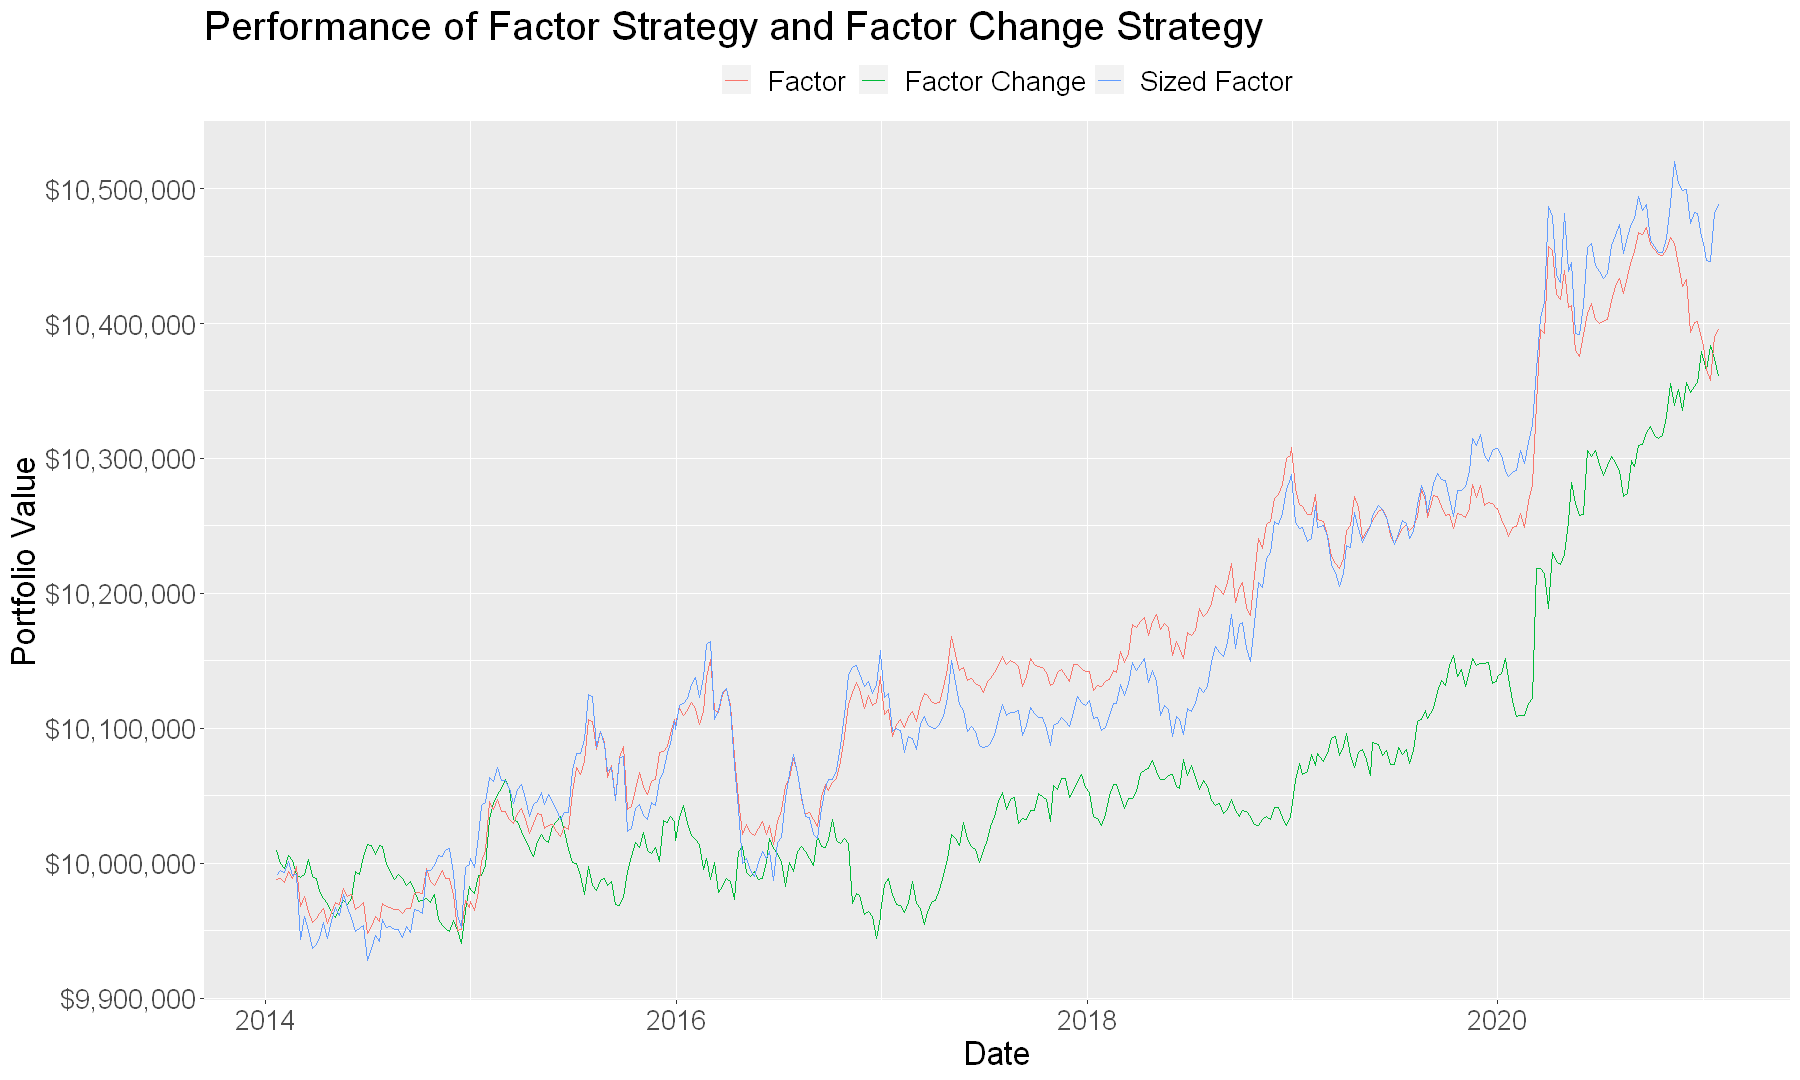

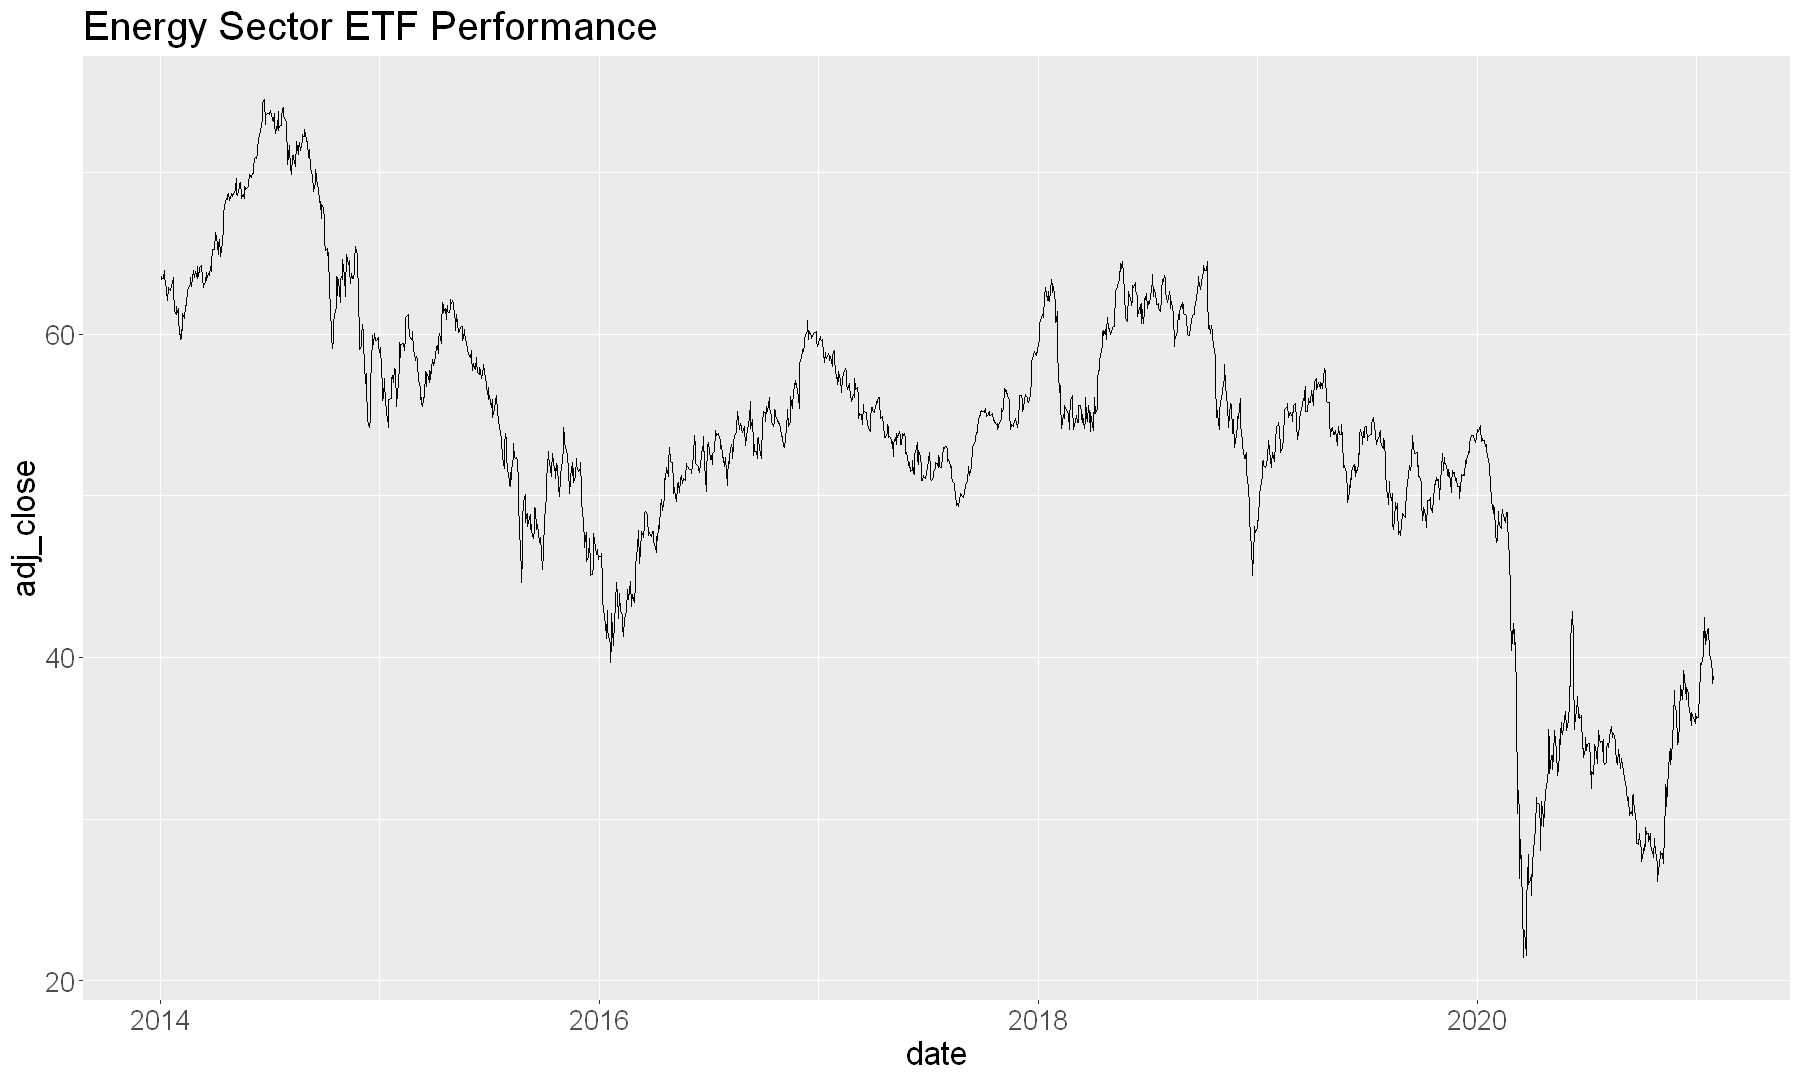

In [19]:
fig(15,9)

kable(stats_table, caption = 'Strategy Statistics')
strategy_plot
XLE_plot

The time period we looked at was extremely rough for the energy sector, specifically, in 2014 through 2017. The **sized factor** proved to be the best performing strategy even though it proved to have the highest max drawdown. The sizing element seemed to provide a better risk adjusted return even though it increased the portfolios concentration in 20 names to 80%.   

Even though a 4.95% over a roughly 7 year period is not fantastic, it is still materially better than the performance of the overall energy sector. I attached a plot of the SPDR XLE ETF for reference. It is interesting to see that the strategy looking at factor changes had a much smaller drawdown in early 2016. 